In [114]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
dataset=pd.read_csv('./Data/olympics_100m.csv')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


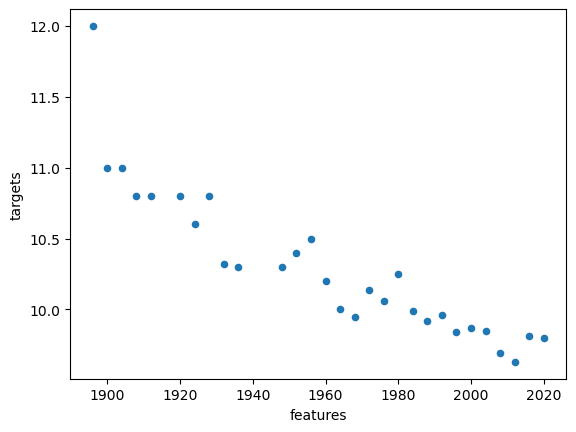

In [115]:
#plot
if dataset.shape[1]==2:
    dataset.plot.scatter(x='features',y='targets')

In [116]:
from ridge import Ridge_Regression
X=dataset.drop('targets',axis=1).values.reshape(-1,dataset.shape[1]-1)
Y=dataset['targets'].values.reshape(-1,1)
## given the low amount of data available we decided to do a leave-one-out K-fold cross validation
## the parameter lambda follows a coarse to fine approach
## the coarse search is done with a step of 0.1 and the fine search with a step of 0.01
lambda_values=np.linspace(0,500,num=(500+1))
k=5
fold_size=len(X)//k
# generate the intervals for the coarse to fine approach from 1 to 10^-20
for subinterval in np.array(10.0 ** np.arange(0, -20, -1)):
    lambda_mses=[]
    print('subinterval: ',subinterval)
    for lambda_value in lambda_values:
        ridge=Ridge_Regression(lambda_value)
        mses=[]
        for i in range(k):
            # K-fold cross validation (take the data from the i-th fold as test data)
            Xi,Yi=np.concatenate((X[:i*fold_size],X[(i+1)*fold_size:]),axis=0),np.concatenate((Y[:i*fold_size],Y[(i+1)*fold_size:]),axis=0)
            ridge.Train(Xi,Yi)
            y_pred=ridge.Predict(X[i*fold_size:(i+1)*fold_size])
            mses.append(((Y[i*fold_size:(i+1)*fold_size]-y_pred)**2).mean())
        lambda_mses.append(np.mean(mses))
        print('lambda: ',lambda_value,' mse: ',np.mean(mses))
    print('best lambda atm: ',lambda_values[np.argmin(lambda_mses)])
    lambda_values=np.linspace(max(lambda_values[np.argmin(lambda_mses)]-1,0)*subinterval,lambda_values[np.argmin(lambda_mses)]+1*subinterval,num=(20+1))
lambda_value=lambda_values[np.argmin(lambda_mses)]

subinterval:  1.0
lambda:  0.0  mse:  0.07687107842114525
lambda:  1.0  mse:  0.6096102698322838
lambda:  2.0  mse:  0.6130717203459731
lambda:  3.0  mse:  0.614234200469763
lambda:  4.0  mse:  0.614817090130377
lambda:  5.0  mse:  0.6151673612844192
lambda:  6.0  mse:  0.6154011050957632
lambda:  7.0  mse:  0.6155681815757512
lambda:  8.0  mse:  0.6156935558046959
lambda:  9.0  mse:  0.6157911111489651
lambda:  10.0  mse:  0.6158691838799097
lambda:  11.0  mse:  0.6159330819999127
lambda:  12.0  mse:  0.6159863458372259
lambda:  13.0  mse:  0.616031427331803
lambda:  14.0  mse:  0.6160700784327293
lambda:  15.0  mse:  0.6161035842533781
lambda:  16.0  mse:  0.6161329088548789
lambda:  17.0  mse:  0.6161587896107041
lambda:  18.0  mse:  0.6161818001360639
lambda:  19.0  mse:  0.6162023933566578
lambda:  20.0  mse:  0.6162209316640438
lambda:  21.0  mse:  0.6162377084598271
lambda:  22.0  mse:  0.6162529638271825
lambda:  23.0  mse:  0.6162668961161317
lambda:  24.0  mse:  0.61627967063

In [117]:
ridge=Ridge_Regression(lambda_value)
ridge.Train(X,Y)
x=np.array([2010,2012,2014,2016,2018,2020]).reshape(-1,1)
y_pred=ridge.Predict(x.reshape(-1,1))
from sklearn.linear_model import Ridge
ridge_sklearn=Ridge(alpha=lambda_value)
ridge_sklearn.fit(X,Y)
y_pred_sklearn=ridge_sklearn.predict(x.reshape(-1,1))
for i in range(len(X)):
    print('year: ',X[i],' time: ',Y[i])
for i in range(len(x)):
    print('year: ',x[i],' time: ',y_pred[i])
    print('scikit: year: ',x[i],' time: ',y_pred_sklearn[i])

year:  [1896]  time:  [12.]
year:  [1900]  time:  [11.]
year:  [1904]  time:  [11.]
year:  [1908]  time:  [10.8]
year:  [1912]  time:  [10.8]
year:  [1920]  time:  [10.8]
year:  [1924]  time:  [10.6]
year:  [1928]  time:  [10.8]
year:  [1932]  time:  [10.32]
year:  [1936]  time:  [10.3]
year:  [1948]  time:  [10.3]
year:  [1952]  time:  [10.4]
year:  [1956]  time:  [10.5]
year:  [1960]  time:  [10.2]
year:  [1964]  time:  [10.]
year:  [1968]  time:  [9.95]
year:  [1972]  time:  [10.14]
year:  [1976]  time:  [10.06]
year:  [1980]  time:  [10.25]
year:  [1984]  time:  [9.99]
year:  [1988]  time:  [9.92]
year:  [1992]  time:  [9.96]
year:  [1996]  time:  [9.84]
year:  [2000]  time:  [9.87]
year:  [2004]  time:  [9.85]
year:  [2008]  time:  [9.69]
year:  [2012]  time:  [9.63]
year:  [2016]  time:  [9.81]
year:  [2020]  time:  [9.8]
year:  [2010]  time:  [9.69091578]
scikit: year:  [2010]  time:  [9.69091578]
year:  [2012]  time:  [9.66644794]
scikit: year:  [2012]  time:  [9.66644794]
year